In [1]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload

In [7]:
import pandas as pd
import numpy as np

In [71]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2023-01-01', '2024-09-24'
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators[['rsi', 'macd', 'stoch_k', 'bollinger_upper', 'atr', 'obv', 'vwap', 'adx']]
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)

## What indicates a larger RSI variance?

In [72]:
indicators['rsi_var'] = indicators['rsi'].rolling(10).std().bfill().ffill()
indicators['price_var'] = indicators['close'].rolling(10).std().bfill().ffill()
indicators['return'] = indicators['close'].pct_change().shift(-1).bfill().ffill()
# indicators['return_var'] = indicators['return'].rolling(10).std().bfill().ffill()

In [73]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
indicators_scaled = pd.DataFrame(scaler.fit_transform(indicators), columns=indicators.columns)

In [74]:
correlation_matrix = indicators_scaled.corr()
correlation_matrix['rsi_var'].sort_values(ascending=False)

rsi_var            1.000000
price_var          0.473380
volume             0.223147
adx                0.157524
atr                0.127224
obv                0.006609
bollinger_upper    0.001043
vwap              -0.003448
close             -0.003871
return            -0.004363
rsi               -0.012338
stoch_k           -0.026761
macd              -0.029222
Name: rsi_var, dtype: float64

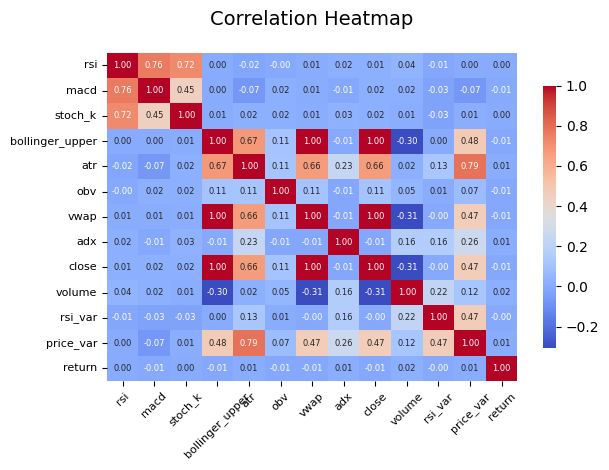

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"shrink": 0.8, "aspect": 20}, annot_kws={"size": 6})
plt.title("Correlation Heatmap", fontsize=14, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()